In [1]:
!pip install opencv-python mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 42.1 MB/s eta 0:00:00


In [2]:
!wget -O /tmp/NanumBarunGothic.ttf "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"

--2024-03-04 15:40:58--  https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/nanumgothic/NanumGothic-Regular.ttf [following]
--2024-03-04 15:40:59--  https://raw.githubusercontent.com/google/fonts/main/ofl/nanumgothic/NanumGothic-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2054744 (2.0M) [application/octet-stream]
Saving to: ‘/tmp/NanumBarunGothic.ttf’

/tmp/NanumBarunGoth 100%[===================>]   1.96M  --.-KB/s    in 0.01s   

2024-03-04 15:40:59 (177 MB/s) - ‘/tmp/NanumBa

In [3]:
import cv2
import os
import mediapipe as mp
import numpy as np
import re
from PIL import Image, ImageDraw, ImageFont
import shutil

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pickle
# word_dict를 불러올 파일 경로
load_path = '/content/drive/MyDrive/third_project/word_dict.pkl'

# 저장된 파일로부터 word_dict 불러오기
with open(load_path, 'rb') as file:
    word_dict = pickle.load(file)

# 딕셔너리를 키 기준으로 정렬하기
word_dict = dict(sorted(word_dict.items()))

# 정렬된 딕셔너리 출력
print("Sorted dictionary:", word_dict)

Sorted dictionary: {'WORD0001': '고민', 'WORD0002': '뻔뻔', 'WORD0003': '수어', 'WORD0004': '남아', 'WORD0005': '눈', 'WORD0006': '독신', 'WORD0007': '음료수', 'WORD0008': '발가락', 'WORD0009': '슬프다', 'WORD0010': '자극', 'WORD0011': '안타깝다', 'WORD0012': '어색하다', 'WORD0013': '여아', 'WORD0014': '외국인', 'WORD0015': '영아', 'WORD0016': '신사', 'WORD0017': '뉴질랜드', 'WORD0018': '나사렛대학교', 'WORD0019': '알아서', 'WORD0020': '장애인', 'WORD0021': '열아홉번째', 'WORD0022': '침착', 'WORD0023': '성실', 'WORD0024': '학교연혁', 'WORD0025': '싫어하다', 'WORD0026': '급하다', 'WORD0027': '필기시험', 'WORD0028': '병문안', 'WORD0029': '검사', 'WORD0030': '결승전', 'WORD0031': '낚시터', 'WORD0032': '낚시대', 'WORD0033': '당뇨병', 'WORD0034': '독서', 'WORD0035': '매표소', 'WORD0036': '면역', 'WORD0037': '감기', 'WORD0038': '배드민턴', 'WORD0039': '변비', 'WORD0040': '병명', 'WORD0041': '보건소', 'WORD0042': '불면증', 'WORD0043': '불행', 'WORD0044': '붕대', 'WORD0045': '사위', 'WORD0046': '설사', 'WORD0047': '성병', 'WORD0048': '방충', 'WORD0049': '소화제', 'WORD0050': '손녀', 'WORD0051': '손자', 'WORD0052': '수면제', 'WORD00

In [6]:
# 이미지 저장

# Mediapipe 손 인식 초기화
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# 비디오 파일과 이미지 저장 경로 설정
video_dir = '/content/drive/MyDrive/third_project/test'
image_dir = '/content/drive/MyDrive/third_project/test_data/images'

# 비디오 파일 리스트 가져오기
video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

for video_file in video_files:
    video_path = os.path.join(video_dir, video_file)
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if 50 <= frame_count <= 100:
            # 프레임에서 손 인식
            results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # 바운딩 박스 좌표 계산
                    h, w, _ = frame.shape
                    min_x, min_y = w, h
                    max_x, max_y = 0, 0
                    for lm in hand_landmarks.landmark:
                        x, y = int(lm.x * w), int(lm.y * h)
                        if x < min_x:
                            min_x = x
                        if x > max_x:
                            max_x = x
                        if y < min_y:
                            min_y = y
                        if y > max_y:
                            max_y = y

                    # 바운딩 박스 중심 및 너비, 높이 계산
                    center_x, center_y = (min_x + max_x) // 2, (min_y + max_y) // 2
                    width, height = max_x - min_x, max_y - min_y

                    # 너비와 높이를 1.5배 증가
                    new_width, new_height = int(width * 1.5), int(height * 1.5)

                    # 새로운 최소 및 최대 x, y 좌표 계산
                    new_min_x, new_max_x = max(0, center_x - new_width // 2), min(w, center_x + new_width // 2)
                    new_min_y, new_max_y = max(0, center_y - new_height // 2), min(h, center_y + new_height // 2)

                    # 파일 이름에서 WORDXXXX 추출
                    match = re.search(r'WORD\d{4}', video_file)
                    if match and match.group(0) in word_dict:
                        # OpenCV 이미지를 PIL 이미지로 변환
                        pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                        draw = ImageDraw.Draw(pil_image)

                        # 한# 한글 폰트 지정 (다운로드한 폰트 파일 경로)
                        font_path = '/tmp/NanumBarunGothic.ttf'  # 다운로드한 폰트 파일 경로
                        font = ImageFont.truetype(font_path, 20)

                        # 한글 텍스트 그리기
                        draw.text((new_min_x, new_min_y - 30), word_dict[match.group(0)], fill=(0, 255, 0), font=font)

                        # PIL 이미지를 OpenCV 이미지로 다시 변환
                        frame = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

                    # 바운딩 박스 그리기
                    cv2.rectangle(frame, (new_min_x, new_min_y), (new_max_x, new_max_y), (0, 255, 0), 2)

                    # 이미지 저장 (JPEG 형식, 품질 90)
                    save_path = os.path.join(image_dir, f'{os.path.splitext(video_file)[0]}_frame{frame_count}.jpg')
                    cv2.imwrite(save_path, frame, [cv2.IMWRITE_JPEG_QUALITY, 90])

        elif frame_count > 100:
            break

    cap.release()

In [7]:
# 라벨 저장

# Mediapipe 손 인식 초기화
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

# 비디오 파일과 이미지 저장 경로 설정
video_dir = '/content/drive/MyDrive/third_project/test'
label_dir = '/content/drive/MyDrive/third_project/test_data/labels'
image_dir = '/content/drive/MyDrive/third_project/test_data/images'

# 디렉토리 생성
os.makedirs(image_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

# 비디오 파일 리스트 가져오기
video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

# 비디오 파일 처리
for video_file in video_files:
    video_path = os.path.join(video_dir, video_file)
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if 50 <= frame_count <= 100:
            # 프레임에서 손 인식
            results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if results.multi_hand_landmarks:
                # 파일 이름에서 WORDXXXX 추출 및 클래스 ID 할당
                match = re.search(r'WORD(\d{4})', video_file)
                if match:
                    class_id = int(match.group(1)) - 1

                    # 라벨 데이터 초기화
                    label_data = []

                    for hand_landmarks in results.multi_hand_landmarks:
                        # 바운딩 박스 좌표 계산
                        h, w, _ = frame.shape
                        min_x, min_y = w, h
                        max_x, max_y = 0, 0
                        for lm in hand_landmarks.landmark:
                            x, y = int(lm.x * w), int(lm.y * h)
                            if x < min_x:
                                min_x = x
                            if x > max_x:
                                max_x = x
                            if y < min_y:
                                min_y = y
                            if y > max_y:
                                max_y = y

                        # 바운딩 박스 중심 및 너비, 높이 계산
                        center_x, center_y = (min_x + max_x) // 2, (min_y + max_y) // 2
                        width, height = max_x - min_x, max_y - min_y

                        # 너비와 높이를 1.5배 증가
                        new_width, new_height = int(width * 1.5), int(height * 1.5)

                        # 새로운 최소 및 최대 x, y 좌표 계산
                        new_min_x, new_max_x = max(0, center_x - new_width // 2), min(w, center_x + new_width // 2)
                        new_min_y, new_max_y = max(0, center_y - new_height // 2), min(h, center_y + new_height // 2)

                        # 정규화된 바운딩 박스 좌표
                        x_center_norm = ((new_min_x + new_max_x) / 2) / w
                        y_center_norm = ((new_min_y + new_max_y) / 2) / h
                        width_norm = (new_max_x - new_min_x) / w
                        height_norm = (new_max_y - new_min_y) / h

                        # 라벨 데이터에 추가
                        label_data.append(f"{class_id} {x_center_norm} {y_center_norm} {width_norm} {height_norm}")

                    # 라벨 파일 저장
                    label_filename = f"{os.path.splitext(video_file)[0]}_frame{frame_count}.txt"
                    label_path = os.path.join(label_dir, label_filename)
                    with open(label_path, 'w') as label_file:
                        for label in label_data:
                            label_file.write(label + "\n")
        elif frame_count > 100:
            break

    cap.release()
hands.close()

In [ ]:
# # 데이터셋의 디렉토리 설정
# dataset_path = '/content/drive/MyDrive/3차 데이터'  # 데이터셋이 위치한 경로로 변경해야 함
# images_path = os.path.join(dataset_path, '/content/drive/MyDrive/3차 데이터/test')  # 이미지가 저장될 경로
# labels_path = os.path.join(dataset_path, '/content/drive/MyDrive/3차 데이터/labels')  # 라벨이 저장될 경로

# # data.yaml 파일 생성
# data_yaml_content = f"""
# train: {images_path}
# # val: optional - 경로 제외

# nc: {len(word_dict)}  # 클래스 수
# names: {list(word_dict.values())}  # word_dict의 value 값들을 클래스 이름으로 사용
# """

# # data.yaml 파일에 내용 쓰기
# with open(os.path.join(dataset_path, 'data.yaml'), 'w') as yaml_file:
#     yaml_file.write(data_yaml_content)

In [ ]:
# 1501 0.5692708333333333 0.7046296296296296 0.08125 0.10555555555555556
# 1501 0.42864583333333334 0.462037037037037 0.06875 0.12407407407407407

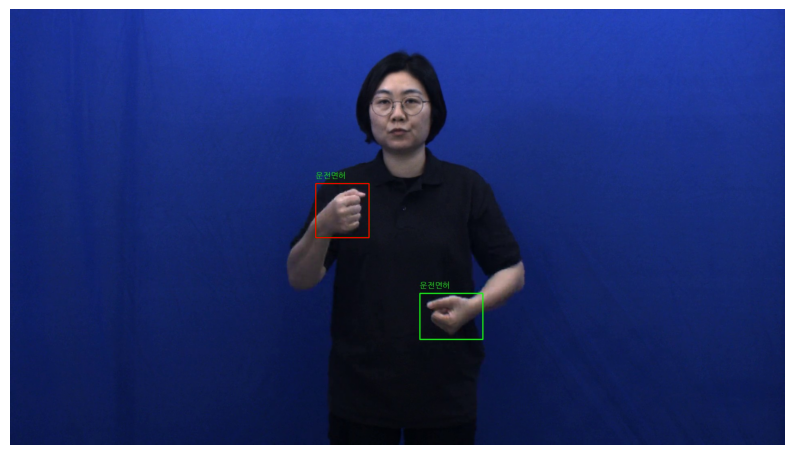

In [ ]:
from matplotlib import pyplot as plt
# Load the image
image_path = '/content/drive/MyDrive/S_L/data/test_result_images/NIA_SL_WORD1501_REAL01_F_frame50.jpg'
image = cv2.imread(image_path)

# Bounding box coordinates provided
class_id = 1501
x_center_norm = 0.42864583333333334
y_center_norm = 0.462037037037037
width_norm = 0.06875
height_norm = 0.12407407407407407

# Image dimensions
height, width, _ = image.shape

# Calculate the bounding box coordinates in pixels
x_center = int(x_center_norm * width)
y_center = int(y_center_norm * height)
box_width = int(width_norm * width)
box_height = int(height_norm * height)

# Calculate the top-left corner of the bounding box
top_left_x = int(x_center - (box_width / 2))
top_left_y = int(y_center - (box_height / 2))

# Draw the bounding box on the image
cv2.rectangle(image, (top_left_x, top_left_y), (top_left_x + box_width, top_left_y + box_height), (0, 0, 255), 2)

# Convert BGR to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()